In [1]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image
import matplotlib.pyplot as plt

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"

# Load the image encoder separately.
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
).to(device)

# Load the base diffusion model and pass the image encoder.
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
).to(device)

# Load the IP-Adapter weights.
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="models",
    weight_name="ip-adapter-plus_sd15.bin",
)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


In [44]:
# Config
imgA = load_image("C:/Users/HanDong/Downloads/male.webp")
imgB = load_image("C:/Users/HanDong/Downloads/female.webp")
prompt = "A baby is laughing, the baby's eyes is filled with curiosity and wonder, reflecting the innocence of early childhood."
negative_prompt = "blur, low quality, bad anatomy"
ALPHA = 0.5                     # weight for image A
pipe.set_ip_adapter_scale(0.4)  # control how strongly the image influence the generation
NUM_INFERENCE_STEPS = 30        # reduce for speed; increase for higher quality
GUIDANCE_SCALE = 12             # adjust to control prompt influence

In [4]:
# Prepare embeddings using IP-Adapter
embA = pipe.prepare_ip_adapter_image_embeds(
    ip_adapter_image=imgA,
    ip_adapter_image_embeds=None,
    device=device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True
)
embB = pipe.prepare_ip_adapter_image_embeds(
    ip_adapter_image=imgB,
    ip_adapter_image_embeds=None,
    device=device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True
)

# Weighted fusion
combined_emb = [ALPHA * a + (1 - ALPHA) * b for a, b in zip(embA, embB)] 

100%|██████████| 30/30 [02:40<00:00,  5.36s/it]


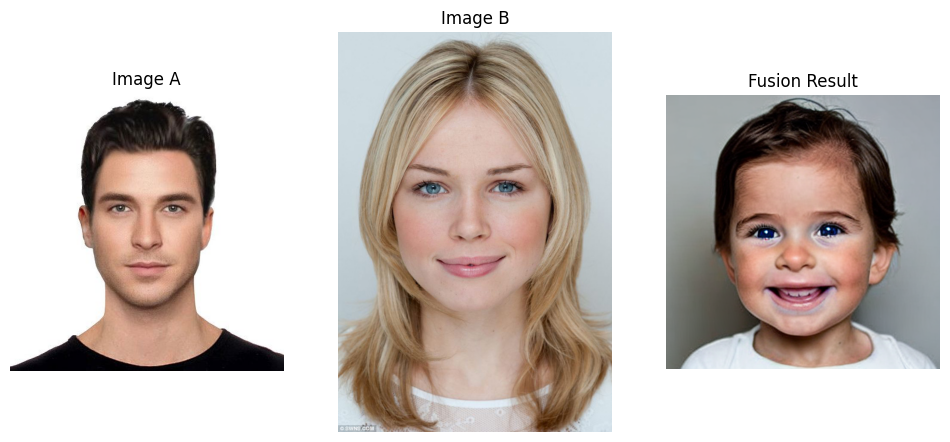

In [ ]:
# Generate image
out = pipe(
    prompt=prompt,
    ip_adapter_image_embeds=combined_emb,
    num_inference_steps=NUM_INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    negative_prompt=negative_prompt
).images[0]

out.save("test.png")

# Show results
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(imgA)
plt.title("Image A")
plt.axis('off') 
plt.subplot(1,3,2)
plt.imshow(imgB)    
plt.title("Image B")
plt.axis('off')
plt.subplot(1,3,3)  
plt.imshow(out)  
plt.title("Fusion Result")
plt.axis('off')
plt.show()